# Final Machine Learning Pipeline

The pipeline features

- open source classes
- in house package classes
- feature selection during pipeline
- score new data

# Reproducibility: Setting the seed

With the aim to ensure reproducibility between runs of the same notebook, but also between the research and production environment, for each step that includes some element of randomness, it is extremely important that we **set the seed**.

In [1]:
# data manipulation and plotting
import pandas as pd
import numpy as np
# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display

from datetime import datetime
from collections import Counter
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# for saving the pipeline
import joblib

# to build the model
from sklearn.linear_model import Lasso
# to evaluate the model
from sklearn.metrics import mean_squared_error, r2_score
# train test split
from sklearn.model_selection import train_test_split
# pre-processing
from sklearn.preprocessing import MinMaxScaler, Binarizer # Binarizer for hugely skewed variables
# pipeline
from sklearn.pipeline import Pipeline
# feature selection
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel


# from feature-engine
from feature_engine.imputation import (
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer,
)

from feature_engine.encoding import (
    RareLabelEncoder,
    OrdinalEncoder,
)

from feature_engine.transformation import LogTransformer
from feature_engine.selection import DropFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

import sklearn_preprocessors as skpp

# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)
#pd.pandas.set_option('display.max_rows', None)

In [2]:
# from sklearn_preprocessors import DataTypeConverter

In [3]:
# load dataset
data = pd.read_csv("../Data/data.csv", parse_dates = ['Built_in_year'])
data.head(2)

,Ids,Location1,Location2,Type,Bedrooms,Bathrooms,Size_in_SqYds,Price_in_millions,Built_in_year,Parking_Spaces,Floors_in_Building,Elevators,Store_Rooms,Lobby_in_Building,Double_Glazed_Windows,Central_Air_Conditioning,Central_Heating,Waste_Disposal,Furnished,Service_Elevators_in_Building,Flooring,Electricity_Backup,Servant_Quarters,Study_Room,Prayer_Room,Powder_Room,Gym,Lounge_or_Sitting_Room,Laundry_Room,Business_Center_or_Media_Room_in_Building,Satellite_or_Cable_TV_Ready,Broadband_Internet_Access,Intercom,Conference_Room_in_Building,Community_Swimming_Pool,Community_Lawn_or_Garden,Community_Gym,Community_Center,First_Aid_or_Medical_Centre,Day_Care_center,Kids_Play_Area,Mosque,Barbeque_Area,Lawn_or_Garden,Swimming_Pool,Sauna,Jacuzzi,Nearby_Schools,Nearby_Hospital,Nearby_Shopping_Malls,Nearby_Restaurants,Nearby_Public_Transport_Service,Other_Nearby_Places,Security_Staff,Maintainance_Staff,Laundry_or_Dry_Cleaning_Facility,Facilities_for_Disabled
0,0,"DHA Phase 6, DHA Defence",DHA Defence,House,6.0,6.0,600.0,220.0,NaT,3,NaN,NaN,NaN,0,1,1,1,0,0,0,1,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,"Saadi Town - Block 3, Saadi Town, Scheme 33",Scheme 33,House,6.0,6.0,240.0,38.5,NaT,1,NaN,NaN,NaN,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Drop Columns and Rows

In [4]:
# drop rows in col 'Price_in_millions' that have missing values
data.drop(data.loc[data['Price_in_millions'].isnull()].index, axis = 0, inplace = True)
print("Shape: ", data.shape)

# drop id, it is just a number given to identify each house
# drop 'Built_in_year', 'Location2', 'Store_Rooms' columns
drop_features = DropFeatures(features_to_drop = ['Ids', 'Location2', 'Store_Rooms'])
data = drop_features.fit_transform(data)

Shape:  (14201, 57)


## Datetime Features

In [5]:
date_time_features = DatetimeFeatures(variables = ['Built_in_year'], 
                                      features_to_extract = ['year'], 
                                      drop_original = True, 
                                      missing_values = 'ignore')

data = date_time_features.fit_transform(data)

## Drop Duplicates

In [6]:
# Using DataFrame.drop_duplicates() to keep first duplicate row
data = data.drop_duplicates(keep = 'first')
# rows and columns of the data
print(f'Shape: {data.shape}')

Shape: (9819, 54)


In [7]:
data.columns

Index(['Location1', 'Type', 'Bedrooms', 'Bathrooms', 'Size_in_SqYds',
       'Price_in_millions', 'Parking_Spaces', 'Floors_in_Building',
       'Elevators', 'Lobby_in_Building', 'Double_Glazed_Windows',
       'Central_Air_Conditioning', 'Central_Heating', 'Waste_Disposal',
       'Furnished', 'Service_Elevators_in_Building', 'Flooring',
       'Electricity_Backup', 'Servant_Quarters', 'Study_Room', 'Prayer_Room',
       'Powder_Room', 'Gym', 'Lounge_or_Sitting_Room', 'Laundry_Room',
       'Business_Center_or_Media_Room_in_Building',
       'Satellite_or_Cable_TV_Ready', 'Broadband_Internet_Access', 'Intercom',
       'Conference_Room_in_Building', 'Community_Swimming_Pool',
       'Community_Lawn_or_Garden', 'Community_Gym', 'Community_Center',
       'First_Aid_or_Medical_Centre', 'Day_Care_center', 'Kids_Play_Area',
       'Mosque', 'Barbeque_Area', 'Lawn_or_Garden', 'Swimming_Pool', 'Sauna',
       'Jacuzzi', 'Nearby_Schools', 'Nearby_Hospital', 'Nearby_Shopping_Malls',
       'N

## Dataset

In [8]:
# rows and columns of the data
print(f'Shape: {data.shape}')
print('-' * 17)

# visualise the dataset
print('')
print('Dataset: ')
print('-' * 10)

data.head(2)

Shape: (9819, 54)
-----------------

Dataset: 
----------


,Location1,Type,Bedrooms,Bathrooms,Size_in_SqYds,Price_in_millions,Parking_Spaces,Floors_in_Building,Elevators,Lobby_in_Building,Double_Glazed_Windows,Central_Air_Conditioning,Central_Heating,Waste_Disposal,Furnished,Service_Elevators_in_Building,Flooring,Electricity_Backup,Servant_Quarters,Study_Room,Prayer_Room,Powder_Room,Gym,Lounge_or_Sitting_Room,Laundry_Room,Business_Center_or_Media_Room_in_Building,Satellite_or_Cable_TV_Ready,Broadband_Internet_Access,Intercom,Conference_Room_in_Building,Community_Swimming_Pool,Community_Lawn_or_Garden,Community_Gym,Community_Center,First_Aid_or_Medical_Centre,Day_Care_center,Kids_Play_Area,Mosque,Barbeque_Area,Lawn_or_Garden,Swimming_Pool,Sauna,Jacuzzi,Nearby_Schools,Nearby_Hospital,Nearby_Shopping_Malls,Nearby_Restaurants,Nearby_Public_Transport_Service,Other_Nearby_Places,Security_Staff,Maintainance_Staff,Laundry_or_Dry_Cleaning_Facility,Facilities_for_Disabled,Built_in_year_year
0,"DHA Phase 6, DHA Defence",House,6.0,6.0,600.0,220.0,3,NaN,NaN,0,1,1,1,0,0,0,1,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
1,"Saadi Town - Block 3, Saadi Town, Scheme 33",House,6.0,6.0,240.0,38.5,1,NaN,NaN,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN


## Load the pre-selected features

In [9]:
# we selected the features in the previous notebook (step 2 or step 5)

features = pd.read_csv('../Data/selected_features.csv')
features = features['0'].to_list() 

# display final feature set
print(f"Selected Features:")
print('-' * 18)
print(features)

Selected Features:
------------------
['Location1', 'Type', 'Bedrooms', 'Bathrooms', 'Size_in_SqYds', 'Floors_in_Building', 'Lobby_in_Building', 'Double_Glazed_Windows', 'Central_Heating', 'Service_Elevators_in_Building', 'Flooring', 'Electricity_Backup', 'Servant_Quarters', 'Study_Room', 'Powder_Room', 'Gym', 'Lounge_or_Sitting_Room', 'Laundry_Room', 'Business_Center_or_Media_Room_in_Building', 'Broadband_Internet_Access', 'Intercom', 'Conference_Room_in_Building', 'Community_Lawn_or_Garden', 'Community_Gym', 'First_Aid_or_Medical_Centre', 'Kids_Play_Area', 'Mosque', 'Nearby_Shopping_Malls', 'Nearby_Restaurants', 'Other_Nearby_Places', 'Security_Staff', 'Bedrooms_na', 'Bathrooms_na', 'Size_in_SqYds_na', 'Floors_in_Building_na', 'Elevators_na', 'Built_in_year_year_na']


In [10]:
len(features)

37

# Separate dataset into train and test

It is important to separate our data intro training and testing set. 

When we engineer features, some techniques learn parameters from data. It is important to learn these parameters only from the train set. This is to avoid over-fitting.

Our feature engineering techniques will learn:

- mean
- mode
- exponents for the log
- category frequency
- and category to number mappings

from the train set.

**Separating the data into train and test involves randomness, therefore, we need to set the seed.**

In [11]:
# Let's separate into train and test set
# Remember to set the seed (random_state for this sklearn function)

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['Price_in_millions'], axis = 1), # predictive variables
    data['Price_in_millions'], # target
    test_size = 0.1, # portion of dataset to allocate to test set
    random_state = 0, # we are setting the seed here
)

X_train.shape, X_test.shape

((8837, 53), (982, 53))

# Target

We apply the logarithm

In [12]:
y_train = np.log(y_train)
y_test = np.log(y_test)

In [13]:
type(y_train)

pandas.core.series.Series

In [14]:
#X_train.head()

In [15]:
#X_test.head()

In [16]:
#y_train.head()

In [17]:
# y_test.head()

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9819 entries, 0 to 14201
Data columns (total 54 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Location1                                  9819 non-null   object 
 1   Type                                       9819 non-null   object 
 2   Bedrooms                                   9097 non-null   float64
 3   Bathrooms                                  8877 non-null   float64
 4   Size_in_SqYds                              9604 non-null   float64
 5   Price_in_millions                          9819 non-null   float64
 6   Parking_Spaces                             9819 non-null   int64  
 7   Floors_in_Building                         1309 non-null   float64
 8   Elevators                                  1191 non-null   float64
 9   Lobby_in_Building                          9819 non-null   int64  
 10  Double_Glazed_Windows  

# Configuration

In [19]:
#### numerical variables with NA in train set
NUMERICAL_VARS_WITH_NA = ['Bedrooms', 'Bathrooms', 'Size_in_SqYds', 'Floors_in_Building', 'Elevators', 'Built_in_year_year']

#### Year Vars/Temporal Vars
TEMPORAL_VARS = ['Built_in_year_year']
REF_VAR = None
# this variable is to calculate the temporal variable, can be dropped afterwards
DROP_FEATURES = ["Built_in_year_year"]

#### categorical variables with NA in train set
# CATEGORICAL_VARS_WITH_NA_FREQUENT = []
# CATEGORICAL_VARS_WITH_NA_MISSING = []

#### data type conversion
FLOAT_COLS = ['Bedrooms', 'Bathrooms', 'Floors_in_Building', 'Elevators']
TO_INT64 = 'int64'

#### variables to log transform
NUMERICALS_LOG_VARS = ["Size_in_SqYds"]

#### variables to binarize
# BINARIZE_VARS = []

#### variables to map
TYPE_VARS = ['Type']

#### variable mappings
TYPE_VARS_MAPPINGS = {'Missing': 0, 'NA': 0, 'NaN': 0, 'Flat': 1, 'House': 2}

# categorical variables to encode
CATEGORICAL_VARS = ['Location1']



# the selected variables
FEATURES = ['Location1', 'Type', 'Bedrooms', 'Bathrooms', 'Size_in_SqYds', 'Floors_in_Building', 'Lobby_in_Building', 
            'Double_Glazed_Windows', 'Central_Heating', 'Service_Elevators_in_Building', 'Flooring', 'Electricity_Backup', 
            'Servant_Quarters', 'Study_Room', 'Powder_Room', 'Gym', 'Lounge_or_Sitting_Room', 'Laundry_Room', 
            'Business_Center_or_Media_Room_in_Building', 'Broadband_Internet_Access', 'Intercom', 'Conference_Room_in_Building', 
            'Community_Lawn_or_Garden', 'Community_Gym', 'First_Aid_or_Medical_Centre', 'Kids_Play_Area', 'Mosque', 
            'Nearby_Shopping_Malls', 'Nearby_Restaurants', 'Other_Nearby_Places', 'Security_Staff', 'Bedrooms_na', 'Bathrooms_na', 
            'Size_in_SqYds_na', 'Floors_in_Building_na', 'Elevators_na', 'Built_in_year_year_na',
            # this one is only to calculate temporal variable:
            #'Built_in_year_year',
]

In [20]:
len(FEATURES)

37

In [21]:
# X_train = X_train[FEATURES]
# X_test = X_test[FEATURES]

# X_train.shape, X_test.shape

# Pipeline - End-to-end

We have 3 steps less, they are commented out. So the pipeline is also simpler:

- the yeo-johnson transformation
- 1 of the mappings
- the selection procedure

this makes the pipeline faster and easier to deploy.

In [22]:
# # Create a pipeline with preprocessing steps and an estimator
# pipeline = Pipeline([
#     ('preprocess', FeatureUnion([('scaling', Pipeline([('selector', FunctionTransformer(lambda X: X[selected_features])),
#             ('scaler', StandardScaler())])),
#         ('feature_selection', Pipeline([
#             ('selector', FunctionTransformer(lambda X: X[selected_features])),
#             ('selector_kbest', SelectKBest(k='all'))
#         ]))
#     ])),
#     ('estimator', LogisticRegression())
# ])

In [23]:
# set up the pipeline
price_pipe = Pipeline([

    # ===== IMPUTATION =====
    
    # add missing indicator
    ('missing_indicator', AddMissingIndicator(variables = NUMERICAL_VARS_WITH_NA)),

    # impute numerical variables with the mean
    ('mean_imputation', MeanMedianImputer(imputation_method = 'mean', variables = NUMERICAL_VARS_WITH_NA)),
    
    # ==== TEMPORAL VARIABLES ====
    
    ('elapsed_time', skpp.ElapsedYearsTransformer(vars = TEMPORAL_VARS, ref_var = REF_VAR)),

    ('drop_features', DropFeatures(features_to_drop = DROP_FEATURES)),
    
    # impute categorical variables with string missing
    # ('missing_imputation', CategoricalImputer(imputation_method = 'missing', variables = CATEGORICAL_VARS_WITH_NA_MISSING)),

    # ('frequent_imputation', CategoricalImputer(imputation_method = 'frequent', variables = CATEGORICAL_VARS_WITH_NA_FREQUENT)),
    
    
    # ==== data types Conversion =====
    
    ('convert_to_int64', skpp.DataTypeConverter(vars = FLOAT_COLS, data_type = TO_INT64)),
    
    # ==== VARIABLE TRANSFORMATION =====
    
    ('log', LogTransformer(variables = NUMERICALS_LOG_VARS)),
    
    # ('yeojohnson', YeoJohnsonTransformer(variables=NUMERICALS_YEO_VARS)),
    
    # ('binarizer', SklearnTransformerWrapper(transformer = Binarizer(threshold = 0), variables = BINARIZE_VARS)),
    
    
    # ==== mappers ====
    
    ('mapper_type_vars', skpp.Mapper(variables = TYPE_VARS, mappings = TYPE_VARS_MAPPINGS)),

    
    # ==== CATEGORICAL ENCODING ====
    
    ('rare_label_encoder', RareLabelEncoder(tol = 0.01, n_categories = 1, variables = CATEGORICAL_VARS)),

    # encode categorical and discrete variables using the target mean
    ('categorical_encoder', OrdinalEncoder(encoding_method = 'ordered', variables = CATEGORICAL_VARS)),
    
    
    # ==== Feature Selection ====
    
    # #include pre-selected features
    # ('preprocess', FeatureUnion([('scaling', Pipeline([('selector', FunctionTransformer(lambda X: X[FEATURES])),
    #         ('scaler', MinMaxScaler())])),
    #     ('feature_selection', Pipeline([
    #         ('selector', FunctionTransformer(lambda X: X[FEATURES])),
    #         ('selector_kbest', SelectKBest(k = 'all'))
    #     ]))
    # ])),
    
    # ==== MinMaxScaler ====
    
    ('scaler', MinMaxScaler()),
    
    # ==== Feature Selection ====

    #('feature_selection', SelectKBest(k = 'all')),
    
    # ==== Model Selection ====
    
    ('selector', SelectFromModel(Lasso(alpha = 0.001, random_state = 0))),
    ('Lasso', Lasso(alpha = 0.001, random_state = 0)),
    
])

In [24]:
X_train.columns

Index(['Location1', 'Type', 'Bedrooms', 'Bathrooms', 'Size_in_SqYds',
       'Parking_Spaces', 'Floors_in_Building', 'Elevators',
       'Lobby_in_Building', 'Double_Glazed_Windows',
       'Central_Air_Conditioning', 'Central_Heating', 'Waste_Disposal',
       'Furnished', 'Service_Elevators_in_Building', 'Flooring',
       'Electricity_Backup', 'Servant_Quarters', 'Study_Room', 'Prayer_Room',
       'Powder_Room', 'Gym', 'Lounge_or_Sitting_Room', 'Laundry_Room',
       'Business_Center_or_Media_Room_in_Building',
       'Satellite_or_Cable_TV_Ready', 'Broadband_Internet_Access', 'Intercom',
       'Conference_Room_in_Building', 'Community_Swimming_Pool',
       'Community_Lawn_or_Garden', 'Community_Gym', 'Community_Center',
       'First_Aid_or_Medical_Centre', 'Day_Care_center', 'Kids_Play_Area',
       'Mosque', 'Barbeque_Area', 'Lawn_or_Garden', 'Swimming_Pool', 'Sauna',
       'Jacuzzi', 'Nearby_Schools', 'Nearby_Hospital', 'Nearby_Shopping_Malls',
       'Nearby_Restaurants', '

In [25]:
# train the pipeline
price_pipe.fit(X_train, y_train)

Pipeline(steps=[('missing_indicator',
                 AddMissingIndicator(variables=['Bedrooms', 'Bathrooms',
                                                'Size_in_SqYds',
                                                'Floors_in_Building',
                                                'Elevators',
                                                'Built_in_year_year'])),
                ('mean_imputation',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['Bedrooms', 'Bathrooms',
                                              'Size_in_SqYds',
                                              'Floors_in_Building', 'Elevators',
                                              'Built_in_year_year'])),
                ('elapsed_time',
                 E...
                 Mapper(mappings={'Flat': 1, 'House': 2, 'Missing': 0, 'NA': 0,
                                  'NaN': 0},
                        variables=['Type'])),
                ('rare_label_encoder',
                 RareLabelEncoder(n_categories=1, tol=0.01,
                                  variables=['Location1'])),
                ('categorical_encoder',
                 OrdinalEncoder(variables=['Location1'])),
                ('scaler', MinMaxScaler()),
                ('selector',
                 SelectFromModel(estimator=Lasso(alpha=0.001, random_state=0))),
                ('Lasso', Lasso(alpha=0.001, random_state=0))])

In [26]:
features_selected = price_pipe.named_steps['selector'].get_feature_names_out()
print(f"Selected features: ", len(features_selected))
print("-" * 18)
print(features_selected)

Selected features:  37
------------------
['x0' 'x1' 'x2' 'x3' 'x4' 'x6' 'x8' 'x9' 'x11' 'x14' 'x15' 'x16' 'x17'
 'x18' 'x20' 'x21' 'x22' 'x23' 'x24' 'x26' 'x27' 'x28' 'x30' 'x31' 'x33'
 'x35' 'x36' 'x44' 'x45' 'x47' 'x48' 'x52' 'x53' 'x54' 'x55' 'x56' 'x57']


In [27]:
features_selected = price_pipe.named_steps['selector'].get_support()
features_selected

array([ True,  True,  True,  True,  True, False,  True, False,  True,
        True, False,  True, False, False,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True, False,  True,
        True,  True, False,  True,  True, False,  True, False,  True,
        True, False, False, False, False, False, False, False,  True,
        True, False,  True,  True, False, False, False,  True,  True,
        True,  True,  True,  True, False])

In [28]:
len(features_selected)

59

In [29]:
type(X_train)

pandas.core.frame.DataFrame

In [30]:
# make predictions for train set
pred_train = price_pipe[:-1].transform(X_train)  # Exclude the last step (Lasso) and only apply transformations
pred_train = price_pipe[-1].predict(pred_train)  # Apply the final Lasso step and make predictions

# determine mse, rmse and r2
print('train mse: {}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred_train)))))
print('train rmse: {}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred_train), squared=False))))
print('train r2: {}'.format(
    r2_score(np.exp(y_train), np.exp(pred_train))))
print()



# make predictions for test set
pred_test = price_pipe[:-1].transform(X_test)  # Exclude the last step (Lasso) and only apply transformations
pred_test = price_pipe[-1].predict(pred_test)  # Apply the final Lasso step and make predictions

# determine mse, rmse and r2
print('test mse: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred_test)))))
print('test rmse: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred_test), squared=False))))
print('test r2: {}'.format(
    r2_score(np.exp(y_test), np.exp(pred_test))))
print()

print('Average house price: ', int(np.exp(y_train).median()))

train mse: 1133
train rmse: 33
train r2: 0.6628158715634062

test mse: 996
test rmse: 31
test r2: 0.6996224433084909

Average house price:  27


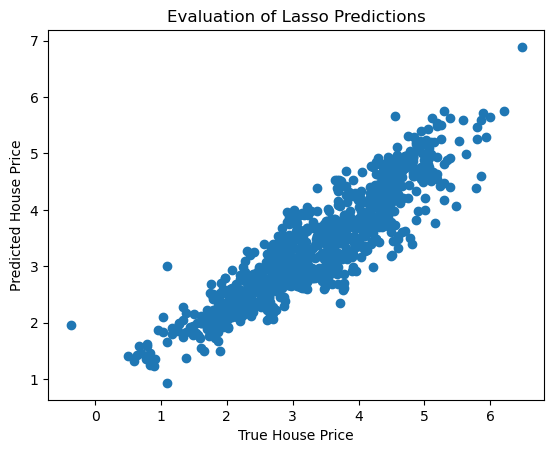

In [31]:
# let's evaluate our predictions respect to the real sale price
plt.scatter(y_test, pred_test)
plt.xlabel('True House Price')
plt.ylabel('Predicted House Price')
plt.title('Evaluation of Lasso Predictions')
plt.show()

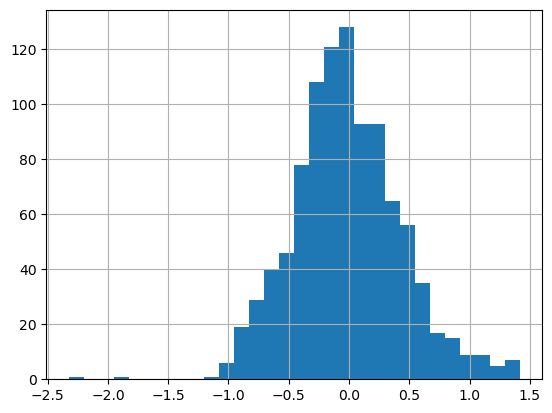

In [32]:
# let's evaluate the distribution of the errors: 
# they should be fairly normally distributed

y_test.reset_index(drop = True, inplace = True)

preds = pd.Series(pred_test)

errors = y_test - preds
errors.hist(bins=30)
plt.show()

In [33]:
# now let's save the scaler

joblib.dump(price_pipe, '../Models/price_pipe.joblib') 

['../Models/price_pipe.joblib']

# Score new data

In [34]:
# load dataset
df = pd.read_csv("../Data/new_data.csv", parse_dates = ['Built_in_year'])
df.head(2)

,Ids,Location1,Location2,Type,Bedrooms,Bathrooms,Size_in_SqYds,Price_in_millions,Built_in_year,Parking_Spaces,Floors_in_Building,Elevators,Store_Rooms,Lobby_in_Building,Double_Glazed_Windows,Central_Air_Conditioning,Central_Heating,Waste_Disposal,Furnished,Service_Elevators_in_Building,Flooring,Electricity_Backup,Servant_Quarters,Study_Room,Prayer_Room,Powder_Room,Gym,Lounge_or_Sitting_Room,Laundry_Room,Business_Center_or_Media_Room_in_Building,Satellite_or_Cable_TV_Ready,Broadband_Internet_Access,Intercom,Conference_Room_in_Building,Community_Swimming_Pool,Community_Lawn_or_Garden,Community_Gym,Community_Center,First_Aid_or_Medical_Centre,Day_Care_center,Kids_Play_Area,Mosque,Barbeque_Area,Lawn_or_Garden,Swimming_Pool,Sauna,Jacuzzi,Nearby_Schools,Nearby_Hospital,Nearby_Shopping_Malls,Nearby_Restaurants,Nearby_Public_Transport_Service,Other_Nearby_Places,Security_Staff,Maintainance_Staff,Laundry_or_Dry_Cleaning_Facility,Facilities_for_Disabled
0,9,"Bahria Apartments, Bahria Town Karachi",Bahria Town Karachi,Flat,4.0,4.0,328.0,28.0,NaT,1,NaN,NaN,NaN,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,56,"Bahria Apartments, Bahria Town Karachi",Bahria Town Karachi,Flat,2.0,2.0,106.0,8.2,NaT,1,NaN,NaN,NaN,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [35]:
# drop rows in col 'Price_in_millions' that have missing values
df.drop(df.loc[df['Price_in_millions'].isnull()].index, axis = 0, inplace = True)
print("Shape: ", df.shape)

# drop id, it is just a number given to identify each house
# drop 'Built_in_year', 'Location2', 'Store_Rooms' columns
drop_features = DropFeatures(features_to_drop = ['Ids', 'Location2', 'Store_Rooms'])
df = drop_features.fit_transform(df)

Shape:  (592, 57)


In [36]:
date_time_features = DatetimeFeatures(variables = ['Built_in_year'], 
                                      features_to_extract = ['year'], 
                                      drop_original = True, 
                                      missing_values = 'ignore')

df = date_time_features.fit_transform(df)

In [37]:
# Using DataFrame.drop_duplicates() to keep first duplicate row
df = df.drop_duplicates(keep = 'first')
# rows and columns of the data
print(f'Shape: {df.shape}')

Shape: (530, 54)


In [38]:
actual_price = df['Price_in_millions']

In [39]:
actual_price = actual_price.reset_index(drop = True)

In [40]:
type(actual_price)

pandas.core.series.Series

In [41]:
len(actual_price)

530

In [42]:
drop_features = DropFeatures(features_to_drop = ['Price_in_millions'])
df = drop_features.fit_transform(df)

In [43]:
#df.head(2)

In [44]:
#len(df)

In [45]:
df.shape

(530, 53)

In [46]:
# make predictions for new data
new_data = price_pipe[:-1].transform(df)  # Exclude the last step (Lasso) and only apply transformations
pred_new_data = price_pipe[-1].predict(new_data)  # Apply the final Lasso step and make predictions

In [47]:
len(pred_new_data)

530

In [48]:
type(pred_new_data)

numpy.ndarray

In [49]:
# convert to series
pred_new_data = pd.Series(np.exp(pred_new_data))
type(pred_new_data)

pandas.core.series.Series

In [50]:
len(pred_new_data)

530

In [51]:
# Create a DataFrame from the two Series
dfx = pd.DataFrame({'Actual_Price': actual_price, 'Predicted_Price': pred_new_data, 'Error': pred_new_data - actual_price})
dfx

,Actual_Price,Predicted_Price,Error
0,28.0,31.057837,3.057837
1,8.2,11.944540,3.744540
2,7.2,10.571296,3.371296
3,24.5,26.915127,2.415127
4,17.5,20.671074,3.171074
...,...,...,...
525,165.0,153.071789,-11.928211
526,200.0,150.718330,-49.281670
527,72.0,48.480006,-23.519994
528,750.0,381.474703,-368.525297


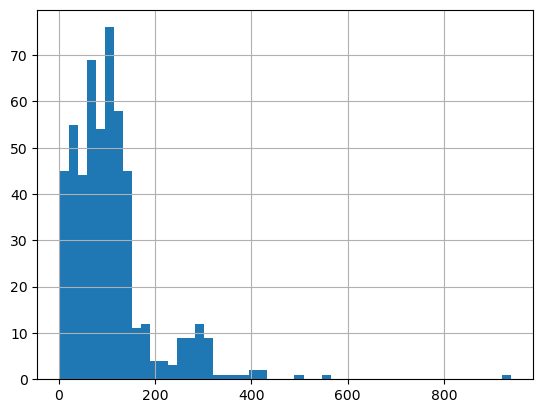

In [52]:
# let's plot the predicted sale prices
pd.Series(pred_new_data).hist(bins = 50)
plt.show()

# Conclusion

Now we are ready for deployment!!!